# Imports and paths

In [1]:
import plotting
import tools
import event_binning
import preprocess_timeseries
import numpy as np
import xarray as xr
import bottleneck as bn

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import colors
import cartopy as cart
import cartopy.crs as ccrs
import cmocean as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

from importlib import reload
import sys
from glob import glob

import xgcm
import gsw
import xnemogcm as xn
import xgcm

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'


/nethome/4302001/miniconda3/lib/python3.9/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [2]:
clim_dir = "/nethome/4302001/local_data/climatology/freeglorys2v4"


In [3]:
mesh_z = xr.open_dataset("/nethome/4302001/local_data/mesh/mesh_zgr_PSY4V2_deg_NA_GoM_subset.nc")
mesh_h = xr.open_dataset("/nethome/4302001/local_data/mesh/mesh_hgr_PSY4V2_deg_NA_GoM_subset.nc")
mask = xr.open_dataset("/nethome/4302001/local_data/mesh/mask_PSY4V2_deg_NA_GoM_subset.nc")
mesh = xr.merge([mesh_z, mesh_h])


In [4]:
bathy = ((mask.tmask * mesh.gdept_1d).sum('z') + mesh.mbathy)


# Basic NASTMW identification function
Note that here we don't select for contiguity of NASTMW or for a minimum thickness of a single layer. This is done only for subsequent EDW computation in `create_EDW_masks.py`.

In [5]:
def identify_edw_model(ds_T, mesh=mesh, strat_crit=0.006, temp_crit=[17, 19], return_thickness=True, minimum_thickness=50):
    """
    Identify EDW in a model dataset.

    Parameters
    ----------
    ds_T : xarray.Dataset
        Dataset containing the temperature variable.
    mesh : xarray.Dataset
        Dataset containing the mesh variables.
    strat_crit : float
        Stratification criterion. Default from literature.
    temp_crit : list
        Temperature criterion. Default from literature
    return_thickness : bool
        If True, returns the thickness of the identified EDW layer.

    Returns
    -------
    criterion_edw : xarray.DataArray
        Boolean array with True where EDW is identified.
    edw_thickness : xarray.DataArray
        Thickness of the identified EDW layer.
    """
    T_grad = ds_T.votemper.differentiate(coord='deptht')

    criterion_temperature = (ds_T.votemper > temp_crit[0]) * (ds_T.votemper < temp_crit[1])
    criterion_strat = np.fabs(T_grad) < strat_crit
    criterion_edw = criterion_strat * criterion_temperature

    if return_thickness:
        cell_thickness_3d = mesh.e3t_0.rename({'z': 'deptht'}).assign_coords(deptht=criterion_edw.deptht) * (criterion_edw * 0 + 1)
        edw_thickness = cell_thickness_3d.where(criterion_edw).sum(dim='deptht', skipna=True)
        return criterion_edw.where(edw_thickness > minimum_thickness, False), edw_thickness.where(edw_thickness > minimum_thickness, 0)
    else:
        return criterion_edw

In [6]:
def compute_edw_volume(ds_T, mesh=mesh, strat_crit=0.006, temp_crit=[17, 19], tvar='votemper', return_cells=False):
    """
    Compute the volume of EDW in a model dataset.

    Parameters
    ----------
    ds_T : xarray.Dataset
        Dataset containing the temperature variable.
    mesh : xarray.Dataset
        Dataset containing the mesh variables.
    strat_crit : float
        Stratification criterion. Default from literature.
    temp_crit : list
        Temperature criterion. Default from literature
    tvar : str
        Name of the temperature variable in ds_T.
    return_cells : bool
        If True, returns the volume of each cell.

    Returns
    -------
    total_volume : xarray.DataArray
        Total volume of EDW.
    edw_volume : xarray.DataArray
        Volume of each cell identified as EDW.
    criterion_edw : xarray.DataArray
        Boolean array with True where EDW is identified.
    """
    
    if type(ds_T) == xr.Dataset:
        da_T = ds_T[tvar]
    elif type(ds_T) == xr.DataArray:
        da_T = ds_T
    else:
        raise

    T_grad = da_T.differentiate(coord='deptht')

    criterion_temperature = (da_T > temp_crit[0]) * (da_T < temp_crit[1])
    criterion_strat = np.fabs(T_grad) < strat_crit
    criterion_edw = criterion_strat * criterion_temperature

    volume = (mesh.e3t_0 * mesh.e2t * mesh.e1t)
    volume = volume.where(volume < 100e3 * 100e3 * 500e3).where(volume >= 0)
    volume = volume.rename({"z": "deptht"}).assign_coords(deptht=criterion_edw.deptht) * (criterion_edw * 0 + 1)
    edw_volume = volume.where(criterion_edw)
    total_volume = edw_volume.sum(skipna=True)

    if return_cells:
        return total_volume, edw_volume, criterion_edw
    else:
        return total_volume

In [7]:
def plot_edw_thickness(edw_thickness, return_fig=False, add_text=None, cmap='turbo', add_colorbar=True):
    fig, ax = plt.subplots(subplot_kw={'projection': cart.crs.PlateCarree()})
    ax.gridlines(draw_labels=['left', 'bottom'])
    ax.add_feature(cart.feature.LAND, zorder=18)
    ax.coastlines(zorder=10)

    levels = np.linspace(50, 400, 15)

    if 'lon' in edw_thickness.coords:
        x = edw_thickness['lon']
        y = edw_thickness['lat']
        title = "EDW Thickness"
    else:
        x = edw_thickness['nav_lon']
        y = edw_thickness['nav_lat']
        try:
            title = f"EDW thickness at {str(edw_thickness.time_counter.data)[:10]}"
        except:
            title = None

    contourf = ax.contourf(x, y, edw_thickness, levels=levels, transform=cart.crs.PlateCarree(), cmap=cmap, extend='both')

    if add_colorbar:
        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="3%", pad=0.1, axes_class=plt.Axes)
        cbar = plt.colorbar(contourf, cax=ax_cb, label="Thickness [m]")
        fig.add_axes(ax_cb)

    ax.set_title(title)
    ax.set_extent([-85, -25, 15, 50], crs=cart.crs.PlateCarree())

    if add_text:
        ax.set_title(ax.get_title() + "\n" + add_text)

    if return_fig:
        return fig, ax
    else:
        plt.show()

# Load WOA data

In [8]:
# WOA_data_march_t = xr.open_dataset(
#     "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav91C0/0.25/woa23_decav91C0_t03_04.nc", decode_times=False)
# WOA_data_march_t = WOA_data_march_t.sel(lon=lon_select, lat=lat_select).isel(time=0)
# WOA_data_march_t.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_march_t.nc")
WOA_data_march_t = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_march_t.nc", decode_times=False)

In [9]:
# WOA_data_march_s = xr.open_dataset(
#     "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/salinity/netcdf/decav91C0/0.25/woa23_decav91C0_s03_04.nc", decode_times=False)
# lon_select = (WOA_data_march_s.lon > -85) * (WOA_data_march_s.lon < 0) 
# lat_select = (WOA_data_march_s.lat > 0) * (WOA_data_march_s.lat < 60) 
# WOA_data_march_s = WOA_data_march_s.sel(lon=lon_select, lat=lat_select).isel(time=0)
# WOA_data_march_s.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_march_s.nc")
WOA_data_march_s = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_march_s.nc", decode_times=False)

In [10]:
# WOA_data_september_t = xr.open_dataset(
#     "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav91C0/0.25/woa23_decav91C0_t09_04.nc", decode_times=False)
# WOA_data_september_t = WOA_data_september_t.sel(lon=lon_select, lat=lat_select).isel(time=0)    
# WOA_data_september_t.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_september_t.nc")
WOA_data_september_t = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_september_t.nc", decode_times=False)

In [11]:
# WOA_data_september_s = xr.open_dataset(
#     "https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/salinity/netcdf/decav91C0/0.25/woa23_decav91C0_s09_04.nc", decode_times=False)
# lon_select = (WOA_data_september_s.lon > -85) * (WOA_data_september_s.lon < 0) 
# lat_select = (WOA_data_september_s.lat > 0) * (WOA_data_september_s.lat < 60) 
# WOA_data_september_s = WOA_data_september_s.sel(lon=lon_select, lat=lat_select).isel(time=0)
# WOA_data_september_s.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_september_s.nc")
WOA_data_september_s = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_september_s.nc", decode_times=False)

In [12]:
# WOA_data_winter = xr.open_dataset("https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav91C0/0.25/woa23_decav91C0_t13_04.nc",
#                                   decode_times=False).sel(lon=lon_select, lat=lat_select).isel(time=0)
# WOA_data_winter.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_winter.nc")
WOA_data_winter = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_winter.nc", decode_times=False)

# WOA_data_summer = xr.open_dataset("https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/temperature/netcdf/decav91C0/0.25/woa23_decav91C0_t15_04.nc",
#                                   decode_times=False).sel(lon=lon_select, lat=lat_select).isel(time=0)
# WOA_data_summer.to_netcdf("/nethome/4302001/local_data/climatology/woa23/WOA_data_summer.nc")
WOA_data_summer = xr.open_dataset("/nethome/4302001/local_data/climatology/woa23/WOA_data_summer.nc", decode_times=False)

# Load climatology data

In `compute_climatology.py` we compute a climatology of the FREEGLORYS files for 1995-2017 (extent of WOA17)

In [13]:
model_clim_T_03 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_T_03_years1995-2017.nc")
model_clim_T_09 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_T_09_years1995-2017.nc")

In [14]:
model_clim_S_03 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_S_03_years1995-2017.nc")
model_clim_S_09 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_S_09_years1995-2017.nc")

In [15]:
model_clim_2D_02 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_02_years1995-2017.nc")
model_clim_2D_03 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_03_years1995-2017.nc")
model_clim_2D_04 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_04_years1995-2017.nc")
model_clim_2D_09 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_09_years1995-2017.nc")

In [16]:
model_clim_2D_03_2000_2015 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_03_years2000-2015.nc")
model_clim_2D_09_2000_2015 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_2D_09_years2000-2015.nc")

In [17]:
model_T_20000301 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_T_2000-03-01.nc")
model_T_20000901 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_T_2000-09-01.nc")
model_T_20050301 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_T_2005-03-01.nc")
model_T_20050901 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_T_2005-09-01.nc")

model_2D_20000301 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_2D_2000-03-01.nc")
model_2D_20000901 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_2D_2000-09-01.nc")
model_2D_20050301 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_2D_2005-03-01.nc")
model_2D_20050901 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4/freeglorys2v4-NorthAtlanticGoM-daily_2D_2005-09-01.nc")

In [19]:
model_clim_U_3 = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_03_years1995-2017.nc")
model_clim_V_3 = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_03_years1995-2017.nc")


In [20]:
model_clim_U_9 = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_09_years1995-2017.nc")
model_clim_V_9 = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_09_years1995-2017.nc")


In [21]:
model_clim_U = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_01_years1995-2017.nc")
for i in range(1, 13):
    model_clim_U += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_{i:02}_years1995-2017.nc")
model_clim_U = model_clim_U/1
model_clim_V = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_01_years1995-2017.nc")
for i in range(1, 13):
    model_clim_V += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_{i:02}_years1995-2017.nc")
model_clim_V = model_clim_V/12

In [22]:
model_clim_U_FMA = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_01_years1995-2017.nc")
for i in range(2, 5):
    model_clim_U_FMA += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_{i:02}_years1995-2017.nc")
model_clim_U_FMA = model_clim_U_FMA/3

model_clim_V_FMA = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_01_years1995-2017.nc")
for i in range(2, 5):
    model_clim_V_FMA += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_{i:02}_years1995-2017.nc")
model_clim_V_FMA = model_clim_V_FMA/3

In [23]:
model_clim_U_ASO = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_01_years1995-2017.nc")
for i in range(8, 11):
    model_clim_U_ASO += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_U_{i:02}_years1995-2017.nc")
model_clim_U_ASO = model_clim_U_ASO/3

model_clim_V_ASO = xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_01_years1995-2017.nc")
for i in range(8, 11):
    model_clim_V_ASO += xr.open_dataset(f"{clim_dir}/freeglorys2v4-NorthAtlanticGoM-climatology_V_{i:02}_years1995-2017.nc")
model_clim_V_ASO = model_clim_V_ASO/3

In [24]:
data_dir_mesh = "/nethome/4302001/local_data/mesh/"
aux_files = list(sorted(glob(data_dir_mesh + "*GoM_subset.nc")))

domcfg = xn.open_domain_cfg(files=aux_files)

In [25]:
bathy = ((domcfg.tmask * domcfg.gdept_1d).sum('z_c') + domcfg.mbathy)


In [26]:
ds_clim_UV = xn.process_nemo(domcfg=domcfg, positions=[
    (model_clim_U.expand_dims('time_counter'), "U"),
    (model_clim_V.expand_dims('time_counter'), "V")])

ds_clim_UV = xn._merge_nemo_and_domain_cfg(nemo_ds=ds_clim_UV, domcfg=domcfg.drop(['x', 'y'])).expand_dims(dim='time')

In [27]:
ds_clim_UV_3 = xn.process_nemo(domcfg=domcfg, positions=[
    (model_clim_U_3.expand_dims('time_counter'), "U"),
    (model_clim_V_3.expand_dims('time_counter'), "V")])

ds_clim_UV_9 = xn.process_nemo(domcfg=domcfg, positions=[
    (model_clim_U_9.expand_dims('time_counter'), "U"),
    (model_clim_V_9.expand_dims('time_counter'), "V")])

ds_clim_UV_3 = xn._merge_nemo_and_domain_cfg(nemo_ds=ds_clim_UV_3, domcfg=domcfg.drop(['x', 'y'])).expand_dims(dim='time')
ds_clim_UV_9 = xn._merge_nemo_and_domain_cfg(nemo_ds=ds_clim_UV_9, domcfg=domcfg.drop(['x', 'y'])).expand_dims(dim='time')


In [28]:
ds_clim_UV_FMA = xn.process_nemo(domcfg=domcfg, positions=[
    (model_clim_U_FMA.expand_dims('time_counter'), "U"),
    (model_clim_V_FMA.expand_dims('time_counter'), "V")])

ds_clim_UV_FMA = xn._merge_nemo_and_domain_cfg(nemo_ds=ds_clim_UV_FMA, domcfg=domcfg.drop(['x', 'y'])).expand_dims(dim='time')

In [29]:
ds_clim_UV_ASO = xn.process_nemo(domcfg=domcfg, positions=[
    (model_clim_U_ASO.expand_dims('time_counter'), "U"),
    (model_clim_V_ASO.expand_dims('time_counter'), "V")])


ds_clim_UV_ASO = xn._merge_nemo_and_domain_cfg(nemo_ds=ds_clim_UV_ASO, domcfg=domcfg.drop(['x', 'y'])).expand_dims(dim='time')

In [30]:
grid = xgcm.Grid(ds_clim_UV_3, metrics=xn.get_metrics(ds_clim_UV_3), periodic=False)


# Identify gyre and gulf stream separation in MOi data

In [31]:
def plot_streamfunction(field, title=None):
    fig = plt.figure(figsize=(6, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.05], height_ratios=[1])
    ax = fig.add_subplot(gs[0, 0], projection=cart.crs.PlateCarree())

    gl = ax.gridlines(draw_labels=['left', 'bottom'], linewidth=0.5, linestyle='--')

    psiplot = ax.contourf(domcfg.glamf, domcfg.gphif, field, transform=cart.crs.PlateCarree(),
                          levels=np.arange(-40, 40.1, 5), extend='both', cmap='RdBu_r')
    ax.contour(domcfg.glamf, domcfg.gphif, field, levels=np.arange(-40, 40.1, 10), colors='black', linewidths=1)

    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
    ax.set_extent([-85, -30, 15, 50])
    ax.set_title(title)

    cbar = fig.colorbar(psiplot, shrink = 0.7, label="Transport [Sv]")
    plt.tight_layout()

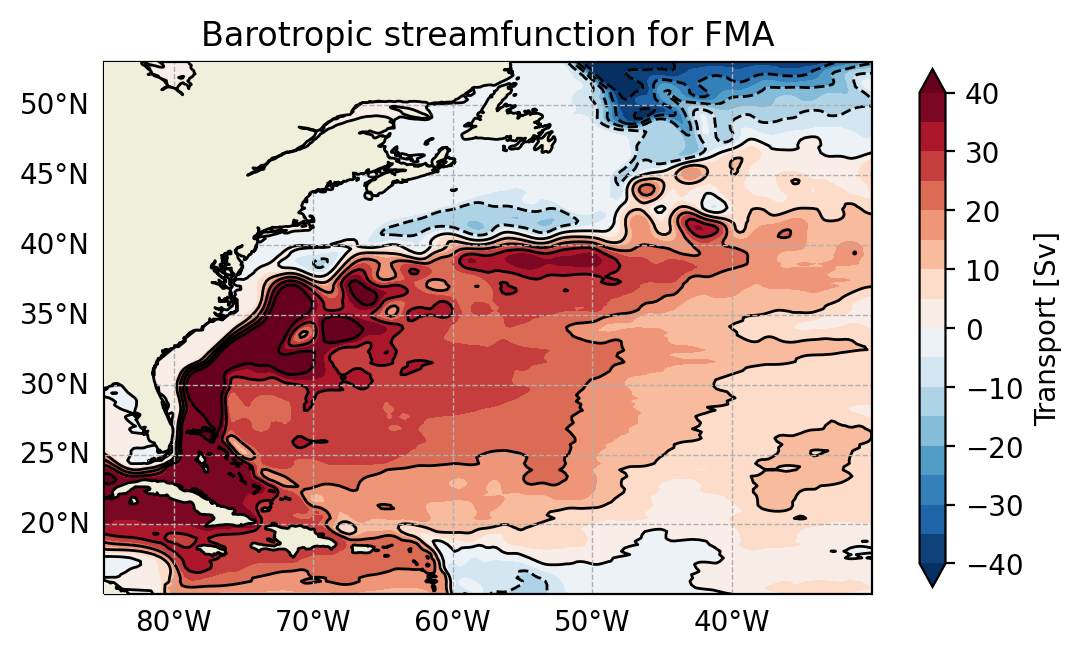

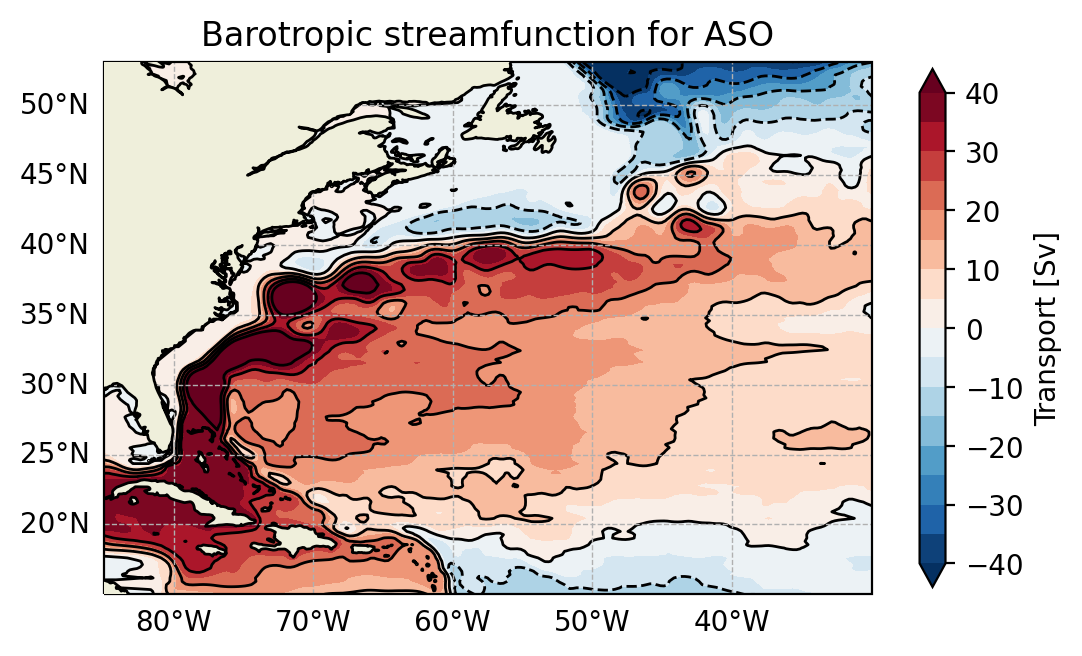

In [32]:
psi_FMA = grid.cumint((ds_clim_UV_FMA.vomecrty * ds_clim_UV_FMA.e3t_1d).sum(dim='z_c'), 'X').compute().isel(time=0, t=0) * 1e-6
psi_ASO = grid.cumint((ds_clim_UV_ASO.vomecrty * ds_clim_UV_ASO.e3t_1d).sum(dim='z_c'), 'X').compute().isel(time=0, t=0) * 1e-6

plot_streamfunction(psi_FMA, title="Barotropic streamfunction for FMA")
plot_streamfunction(psi_ASO, title="Barotropic streamfunction for ASO")



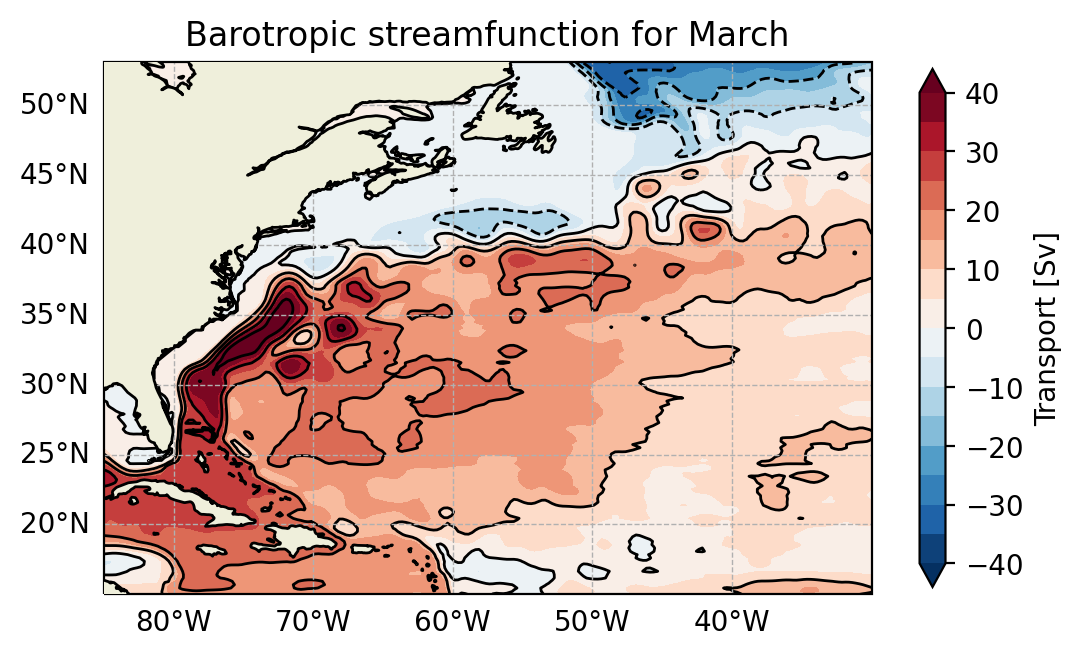

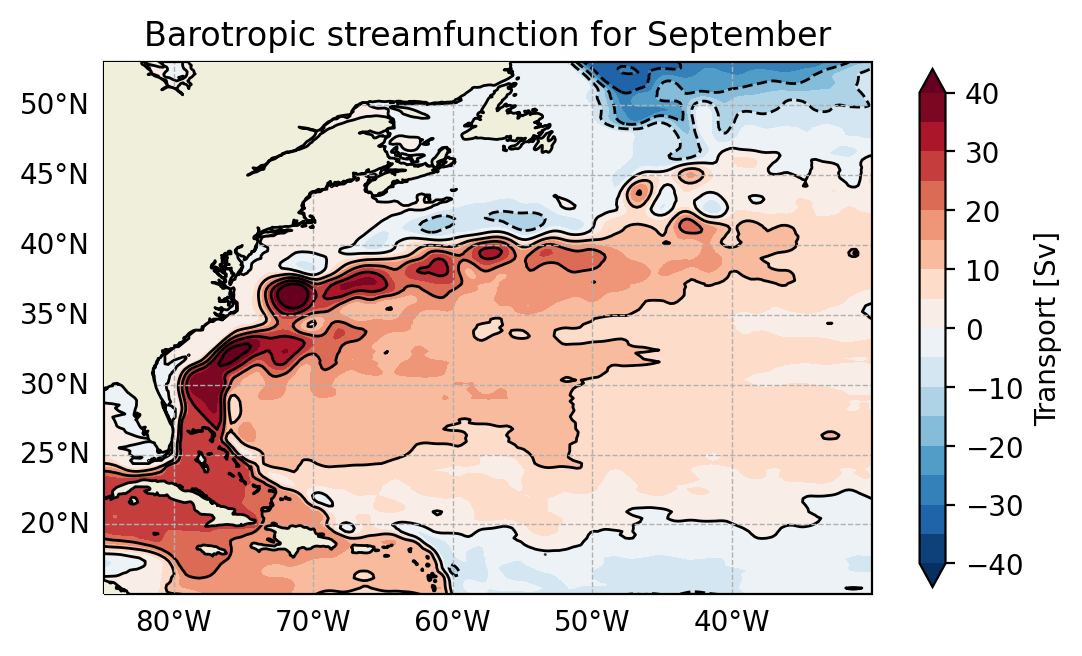

In [33]:
psi_3 = grid.cumint((ds_clim_UV_3.vomecrty * ds_clim_UV_3.e3t_1d).sum(dim='z_c'), 'X').compute().isel(time=0, t=0) * 1e-6
psi_9 = grid.cumint((ds_clim_UV_9.vomecrty * ds_clim_UV_9.e3t_1d).sum(dim='z_c'), 'X').compute().isel(time=0, t=0) * 1e-6

plot_streamfunction(psi_3, title="Barotropic streamfunction for March")
plot_streamfunction(psi_9, title="Barotropic streamfunction for September")


# Investigate temperature and salinity biases

In [40]:
WOA_march_t_interp = WOA_data_march_t.t_an.interp(
    lon=model_clim_T_03.nav_lon, lat=model_clim_T_03.nav_lat, depth=model_clim_T_03.isel(deptht=slice(0, 45)).deptht)
WOA_september_t_interp = WOA_data_september_t.t_an.interp(
    lon=model_clim_T_09.nav_lon, lat=model_clim_T_09.nav_lat, depth=model_clim_T_09.isel(deptht=slice(0, 45)).deptht)

In [41]:
WOA_march_s_interp = WOA_data_march_s.s_an.interp(
    lon=model_clim_S_03.nav_lon, lat=model_clim_S_03.nav_lat, depth=model_clim_S_03.isel(deptht=slice(0, 45)).deptht)
WOA_september_s_interp = WOA_data_september_s.s_an.interp(
    lon=model_clim_S_09.nav_lon, lat=model_clim_S_09.nav_lat, depth=model_clim_S_09.isel(deptht=slice(0, 45)).deptht)

In [42]:
model_clim_T_03_2000_2015 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_T_03_years2000-2015.nc")
model_clim_T_09_2000_2015 = xr.open_dataset(
    "/nethome/4302001/local_data/climatology/freeglorys2v4/freeglorys2v4-NorthAtlanticGoM-climatology_T_09_years2000-2015.nc")

In [44]:
bias_march_t_5m = (model_clim_T_03.votemper.interp(deptht=5) - WOA_data_march_t.t_an.sel(depth=5).interp(lon=model_clim_T_03.nav_lon, lat=model_clim_T_03.nav_lat))
bias_march_t_200m = (model_clim_T_03.votemper.interp(deptht=200) - WOA_data_march_t.t_an.sel(depth=200).interp(lon=model_clim_T_03.nav_lon, lat=model_clim_T_03.nav_lat))
bias_march_t_500m = (model_clim_T_03.votemper.interp(deptht=500) - WOA_data_march_t.t_an.sel(depth=500).interp(lon=model_clim_T_03.nav_lon, lat=model_clim_T_03.nav_lat))

bias_september_t_5m = (model_clim_T_09.votemper.interp(deptht=5) - WOA_data_september_t.t_an.sel(depth=5).interp(lon=model_clim_T_09.nav_lon, lat=model_clim_T_09.nav_lat))
bias_september_t_200m = (model_clim_T_09.votemper.interp(deptht=200) - WOA_data_september_t.t_an.sel(depth=200).interp(lon=model_clim_T_09.nav_lon, lat=model_clim_T_09.nav_lat))
bias_september_t_500m = (model_clim_T_09.votemper.interp(deptht=500) - WOA_data_september_t.t_an.sel(depth=500).interp(lon=model_clim_T_09.nav_lon, lat=model_clim_T_09.nav_lat))

In [45]:
bias_march_s_5m = (model_clim_S_03.vosaline.interp(deptht=5) - WOA_data_march_s.s_an.sel(depth=5).interp(lon=model_clim_S_03.nav_lon, lat=model_clim_S_03.nav_lat))
bias_march_s_200m = (model_clim_S_03.vosaline.interp(deptht=200) - WOA_data_march_s.s_an.sel(depth=200).interp(lon=model_clim_S_03.nav_lon, lat=model_clim_S_03.nav_lat))
bias_march_s_500m = (model_clim_S_03.vosaline.interp(deptht=500) - WOA_data_march_s.s_an.sel(depth=500).interp(lon=model_clim_S_03.nav_lon, lat=model_clim_S_03.nav_lat))

bias_september_s_5m = (model_clim_S_09.vosaline.interp(deptht=5) - WOA_data_september_s.s_an.sel(depth=5).interp(lon=model_clim_S_09.nav_lon, lat=model_clim_S_09.nav_lat))
bias_september_s_200m = (model_clim_S_09.vosaline.interp(deptht=200) - WOA_data_september_s.s_an.sel(depth=200).interp(lon=model_clim_S_09.nav_lon, lat=model_clim_S_09.nav_lat))
bias_september_s_500m = (model_clim_S_09.vosaline.interp(deptht=500) - WOA_data_september_s.s_an.sel(depth=500).interp(lon=model_clim_S_09.nav_lon, lat=model_clim_S_09.nav_lat))

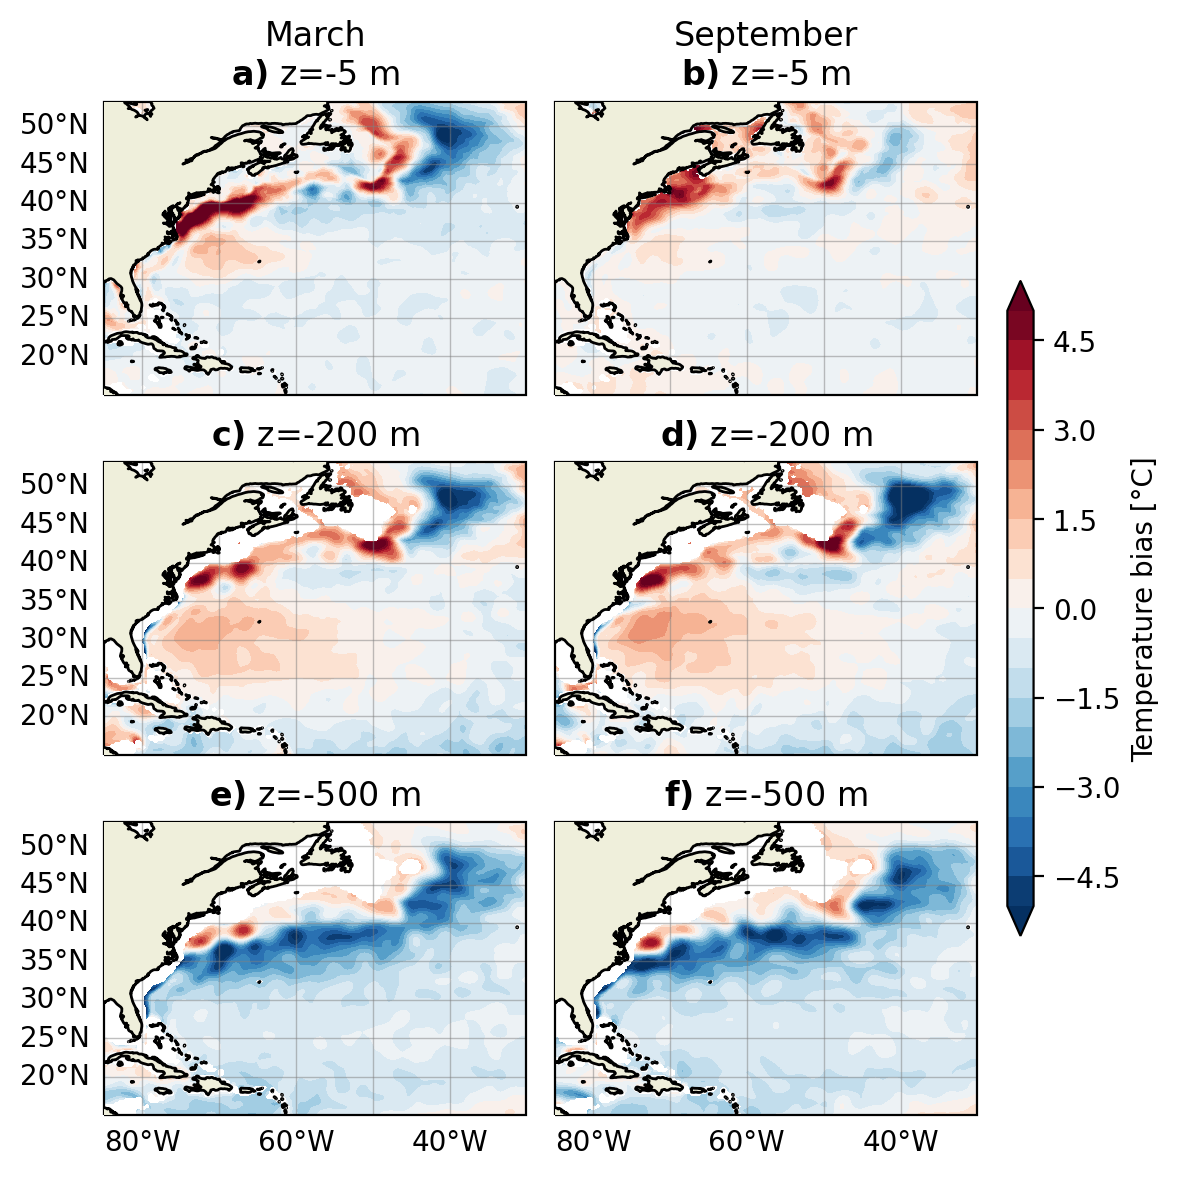

In [49]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.03])
gs_figs = gs[0].subgridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.1)
gs_cb = gs[1].subgridspec(3, 1, height_ratios=[0.25, 1, 0.25], hspace=0.1)

datasets = [(bias_march_t_5m, 5), (bias_september_t_5m, 5), (bias_march_t_200m, 200),
            (bias_september_t_200m, 200), (bias_march_t_500m, 500), (bias_september_t_500m, 500)]
labels = [r"$\bf{a)}$", r"$\bf{b)}$", r"$\bf{c)}$", r"$\bf{d)}$", r"$\bf{e)}$", r"$\bf{f)}$"]

x = bias_march_t_5m['nav_lon']
y = bias_march_t_5m['nav_lat']

for i, (dataset, depth) in enumerate(datasets):
    row = (i) // 2
    col = (i) % 2
    ax = fig.add_subplot(gs_figs[row, col], projection=cart.crs.PlateCarree())
    field = ax.contourf(x, y, dataset, transform=cart.crs.PlateCarree(), 
                levels=np.arange(-5, 5.1, 0.5), #levels=np.arange(-2, 2.25, 0.5), 
                cmap='RdBu_r', extend='both')

    if row == 0:
        ax.set_title(f"{'September' if col else 'March'}")
    ax.set_title(ax.get_title()+"\n"+labels[i] + f" z=-{depth} m")
    
    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
    ax.set_extent([-85, -30, 15, 50])

    gridlines = []
    if col == 0:
        gridlines.append('left')
    if row == 2:
        gridlines.append('bottom')
    gl = ax.gridlines(draw_labels=gridlines, linewidth=0.5, color='gray', alpha=0.5)
        

cbar_ax = fig.add_subplot(gs_cb[1])
cbar = plt.colorbar(field, shrink=0.6, cax=cbar_ax,label="Temperature bias [°C]")

#cbar_kwargs={'label': "Temperature bias [°C]"}

# fig.suptitle("Temperature bias, Model (1995-2017) – WOA")
plt.tight_layout()
plt.savefig("output/model_bias_temperature_woa.png", dpi=300, bbox_inches='tight')

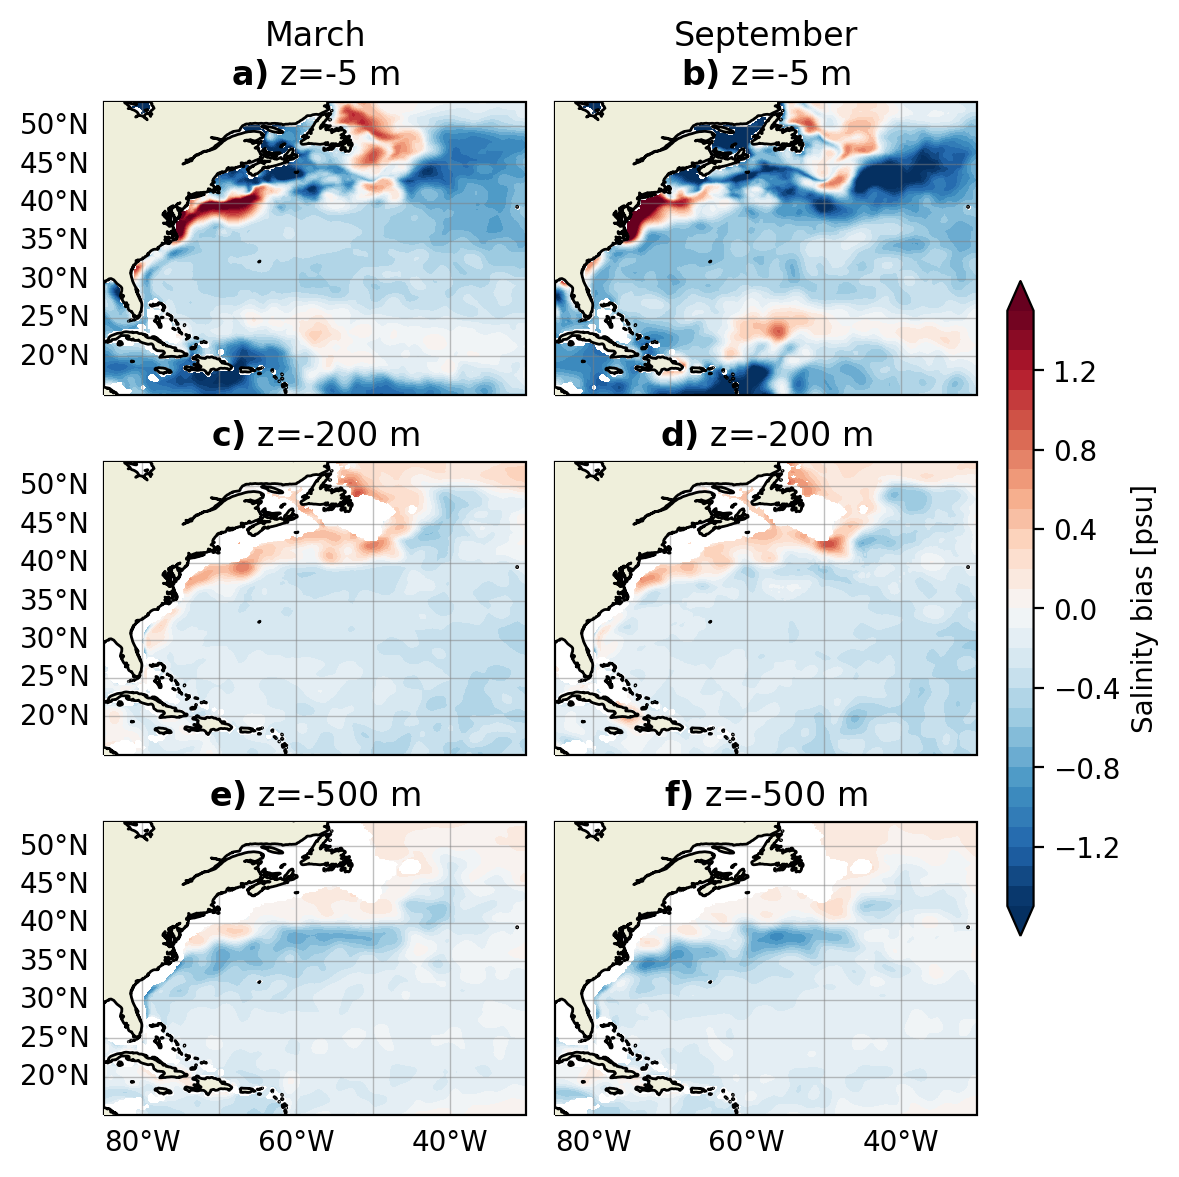

In [50]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.03])
gs_figs = gs[0].subgridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.1)
gs_cb = gs[1].subgridspec(3, 1, height_ratios=[0.25, 1, 0.25], hspace=0.1)

datasets = [(bias_march_s_5m, 5), (bias_september_s_5m, 5), (bias_march_s_200m, 200),
            (bias_september_s_200m, 200), (bias_march_s_500m, 500), (bias_september_s_500m, 500)]
labels = [r"$\bf{a)}$", r"$\bf{b)}$", r"$\bf{c)}$", r"$\bf{d)}$", r"$\bf{e)}$", r"$\bf{f)}$"]

x = bias_march_s_5m['nav_lon']
y = bias_march_s_5m['nav_lat']

for i, (dataset, depth) in enumerate(datasets):
    row = (i) // 2
    col = (i) % 2
    ax = fig.add_subplot(gs_figs[row, col], projection=cart.crs.PlateCarree())
    field = ax.contourf(x, y, dataset, transform=cart.crs.PlateCarree(), 
                levels=np.arange(-1.5, 1.6, 0.1), #levels=np.arange(-2, 2.25, 0.5), 
                cmap='RdBu_r', extend='both')

    if row == 0:
        ax.set_title(f"{'September' if col else 'March'}")
    ax.set_title(ax.get_title()+"\n"+labels[i] + f" z=-{depth} m")
    
    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
    ax.set_extent([-85, -30, 15, 50])

    gridlines = []
    if col == 0:
        gridlines.append('left')
    if row == 2:
        gridlines.append('bottom')
    gl = ax.gridlines(draw_labels=gridlines, linewidth=0.5, color='gray', alpha=0.5)
        

cbar_ax = fig.add_subplot(gs_cb[1])
cbar = plt.colorbar(field, shrink=0.6, cax=cbar_ax,label="Salinity bias [psu]")


plt.tight_layout()
plt.savefig("output/model_bias_salinity_woa.png", dpi=300, bbox_inches='tight')

# MLD

Text(0.5, 1.0, 'Depth of Mixed Layer base \n 2000-03-01')

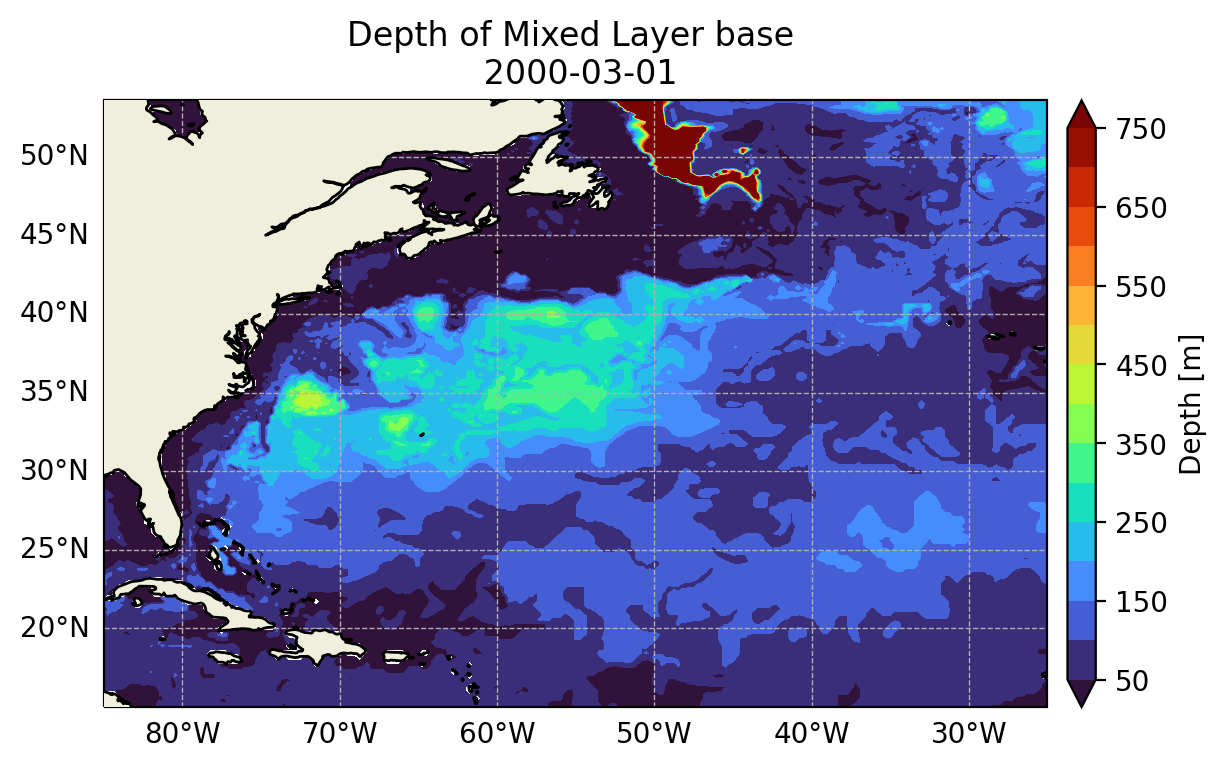

In [51]:
fig = plotting.field_cartopy_colorbar(model_2D_20000301.somxlt02,
                                      levels=np.arange(50, 800, 50), extend='both',  cmap='turbo', cbar_label="Depth [m]")
fig.axes[0].set_title("Depth of Mixed Layer base \n 2000-03-01")

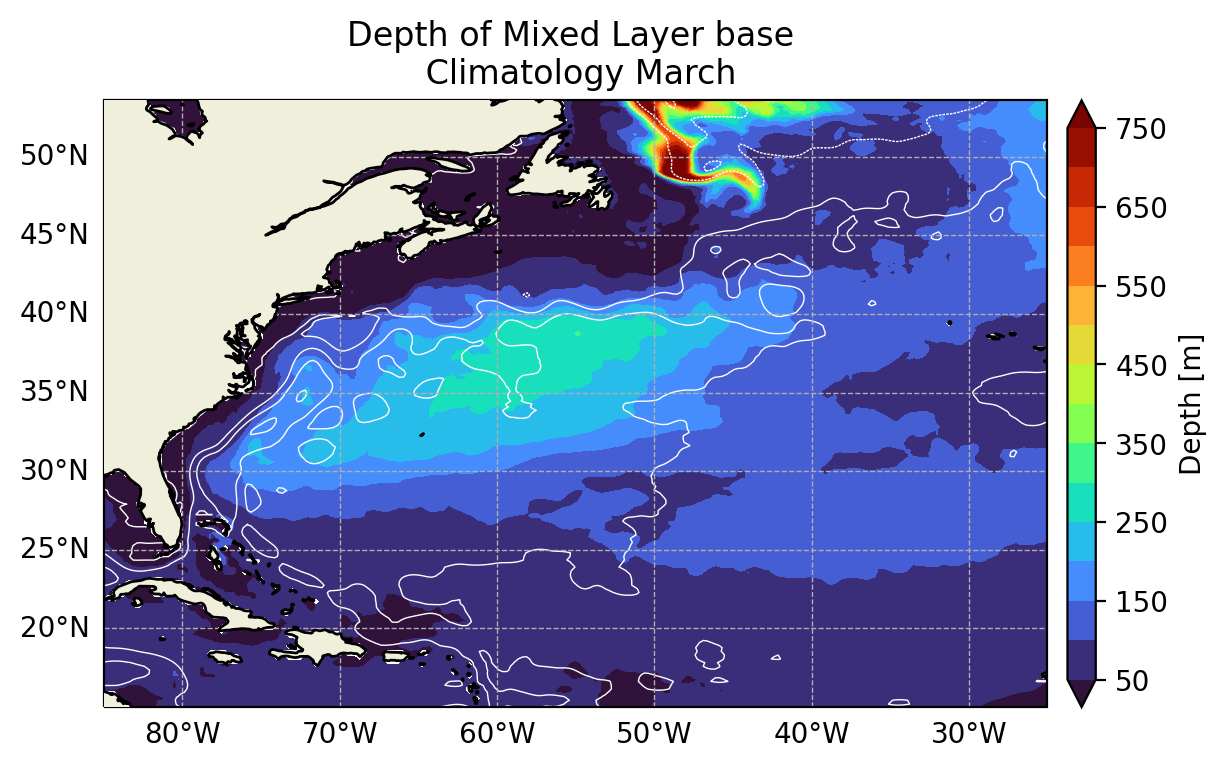

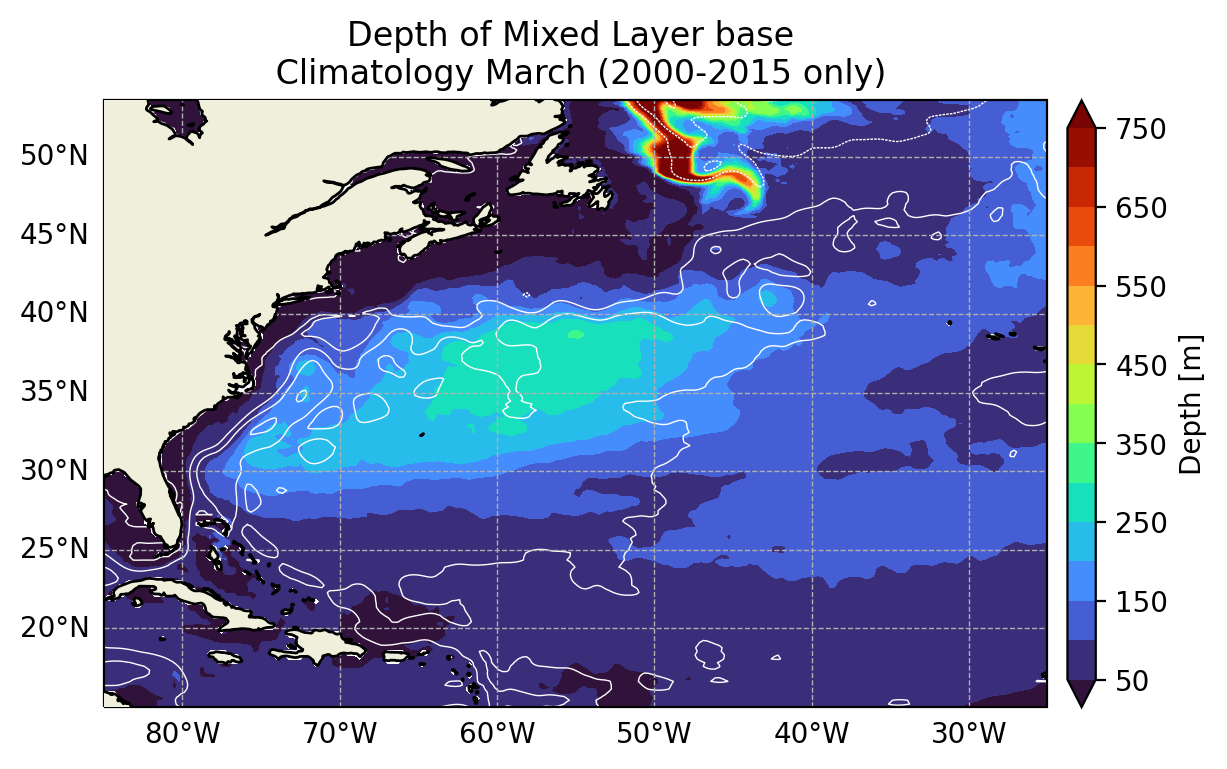

In [52]:
fig = plotting.field_cartopy_colorbar(model_clim_2D_03.somxlt02,
                                      levels=np.arange(50, 800, 50), extend='both',  cmap='turbo', cbar_label="Depth [m]")
fig.axes[0].set_title("Depth of Mixed Layer base \n Climatology March")
fig.axes[0].contour(domcfg.glamf, domcfg.gphif, psi_3, levels=7, colors='white', linewidths=0.5)

fig = plotting.field_cartopy_colorbar(model_clim_2D_03_2000_2015.somxlt02,
                                      levels=np.arange(50, 800, 50), extend='both',  cmap='turbo', cbar_label="Depth [m]")
fig.axes[0].set_title("Depth of Mixed Layer base \n Climatology March (2000-2015 only)")
fig.axes[0].contour(domcfg.glamf, domcfg.gphif, psi_3, levels=7, colors='white', linewidths=0.5)


In [53]:
temp_at_mldbase = model_clim_T_03.votemper.where(model_clim_2D_03.somxlt02>200).interp(deptht=model_clim_2D_03.somxlt02)

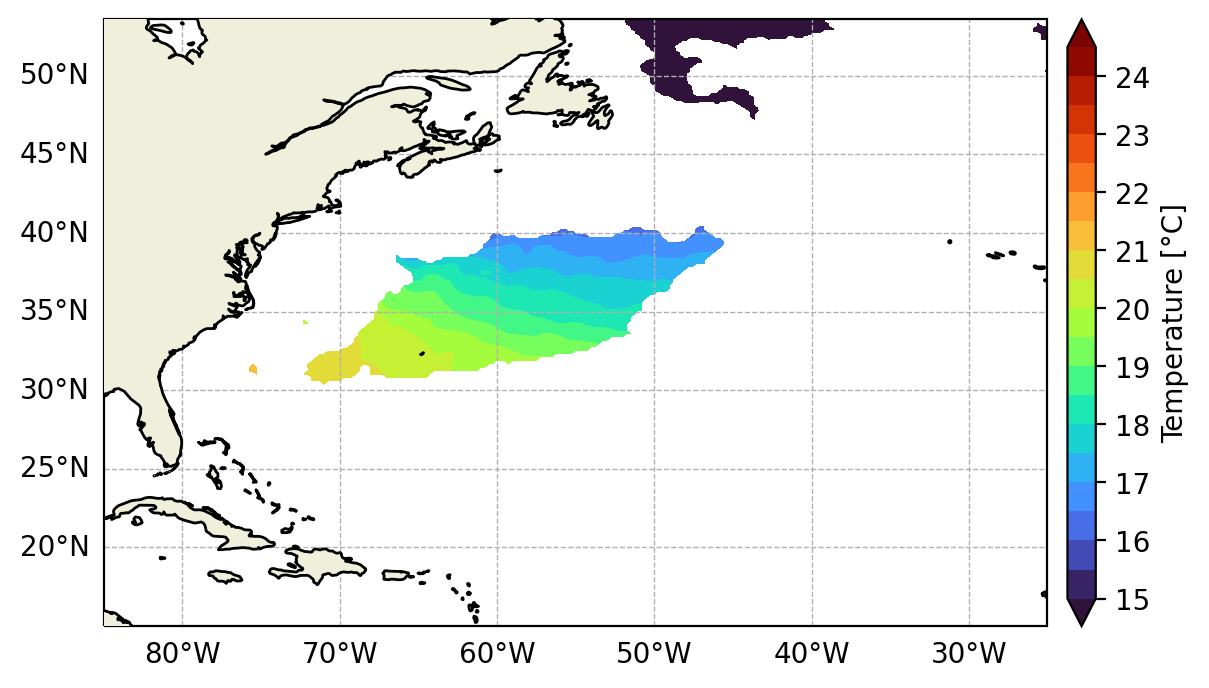

In [54]:
fig = plotting.field_cartopy_colorbar(temp_at_mldbase,
                                      cmap='turbo', levels=np.arange(15, 25, 0.5), extend='both', cbar_label="Temperature [°C]")

Temperature at the base of the mixed layer is between 16.5 – 21 degrees. 17 and 20.5 provides a range that is somewhat smaller to stay closer to the original definition and that of Kwon et al.

In [55]:
def simple_temp_MLD_compute(T_field, temp_thresh = 0.2, thresh_depth = 10, depth_name='deptht', nemo_mode=False):
    """
    Compute the mixed layer depth using a simple threshold method. Assumes depth is positive and increasing downward.

    Parameters
    ----------
    T_field : xarray.DataArray
        Temperature field
    temp_thresh : float
        Temperature threshold in °C
    thresh_depth : float
        Depth at which the threshold is applied
    depth_name : str
        Name of the depth coordinate

    Returns
    -------
    MLD : xarray.DataArray
        Mixed layer depth
    """

    threshold_field = T_field.sel({depth_name : thresh_depth}, method='nearest') - temp_thresh

    simple_bottom = T_field[depth_name][np.isnan(T_field).argmax(depth_name) - 1] # Not the real bottom; depth of bottom cell. Remove the -1 to get depth of first land cell.
    simple_bottom = simple_bottom.where(simple_bottom < 5800, np.nan) # Exclude land

    bottom_cast = ((T_field - threshold_field) < 0).argmax(depth_name)
    top_cast = (bottom_cast - 1).where(bottom_cast > 0, 0)

    bottom_depth = T_field[depth_name][bottom_cast]
    

    if nemo_mode:
        MLD = bottom_depth.where(bottom_depth > 1, simple_bottom)
    else:
        top_depth = T_field[depth_name][top_cast]

        dz = bottom_depth - top_depth

        bottom_temp = T_field.isel({depth_name: bottom_cast})
        top_temp = T_field.isel({depth_name: top_cast})

        temp_gradient = (bottom_temp - top_temp) / dz
        
        MLD = top_depth + (threshold_field - top_temp) / temp_gradient
        MLD = MLD.where(MLD > 0, simple_bottom)

    return MLD

In [56]:
WOA_MLD_march = xr.open_dataset("https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/mld/A5B7/0.25/woa18_A5B7_M0203_04.nc", decode_times=False)

In [57]:
WOA_MLD_march_interp = WOA_MLD_march.M_an.interp(lon=model_clim_2D_03.nav_lon, lat=model_clim_2D_03.nav_lat).isel(time=0, depth=0)
WOA_MLD_march_subset = WOA_MLD_march.M_an.isel(time=0, depth=0).isel(lat=slice(90*4, 150*4), lon=slice(90*4, 180*4))

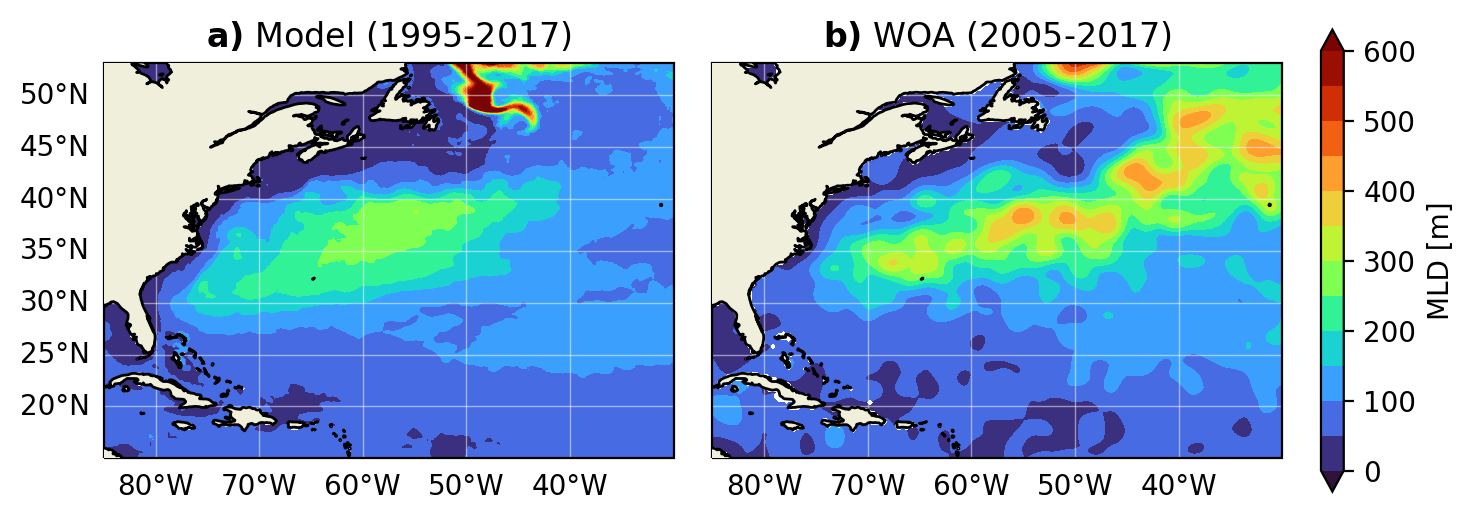

In [58]:
fig = plt.figure(figsize=(8,3))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.1)

ax_mod = fig.add_subplot(gs[0, 0], projection=cart.crs.PlateCarree())
ax_mod.set_title(r"$\bf{a)}$ Model (1995-2017)")
ax_mod.contourf(model_clim_2D_03.nav_lon, model_clim_2D_03.nav_lat, model_clim_2D_03.somxlt02, cmap='turbo', levels=np.arange(0, 601, 50), extend='both')
ax_mod.gridlines(draw_labels=['left', 'bottom'], linewidth=0.5, color='white', alpha=0.5)

ax_woa = fig.add_subplot(gs[0, 1], projection=cart.crs.PlateCarree())
ax_woa.set_title(r"$\bf{b)}$ WOA (2005-2017)")
woa_field = ax_woa.contourf(WOA_MLD_march_subset.lon, WOA_MLD_march_subset.lat, WOA_MLD_march_subset, cmap='turbo', levels=np.arange(0, 601, 50), extend='both')
ax_woa.gridlines(draw_labels=['bottom'], linewidth=0.5, color='white', alpha=0.5)

for ax in [ax_mod, ax_woa]:
    ax.set_extent([-85, -30, 15, 50])
    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')

cbar_ax = fig.add_subplot(gs[0, 2])
cbar = fig.colorbar(woa_field, cax=cbar_ax, label="MLD [m]")

plt.savefig("output/model_woa_mld.png", dpi=300, bbox_inches='tight')

# WOA-model NASTMW

In [59]:
def identify_edw_woa(WOA_data, strat_crit=0.01, return_thickness=True):
    WOA_cell_thickness = xr.DataArray(np.diff(WOA_data.depth_bnds.data, axis=1)[:, 0], coords={'depth': WOA_data.depth})

    T_grad = WOA_data.t_an.differentiate(coord='depth')

    criterion_temperature = (WOA_data.t_an > 17) * (WOA_data.t_an < 19)
    criterion_strat = np.fabs(T_grad) < strat_crit
    criterion_edw = criterion_strat * criterion_temperature

    if return_thickness:
        cell_thickness_3d = WOA_cell_thickness * (criterion_edw * 0 + 1)
        edw_thickness = cell_thickness_3d.where(criterion_edw).sum(dim='depth', skipna=True)
        return criterion_edw, edw_thickness
    else:
        return criterion_edw

In [60]:
ds_clim_EDW_03 = xr.open_dataset("/nethome/4302001/local_data/climatology/freeglorys2v4-NorthAtlanticGoM-climatology_EDW_part_of_outcropping_blob_03_years1995-2017.nc")
ds_clim_EDW_09 = xr.open_dataset("/nethome/4302001/local_data/climatology/freeglorys2v4-NorthAtlanticGoM-climatology_EDW_part_of_outcropping_blob_09_years1995-2017.nc")

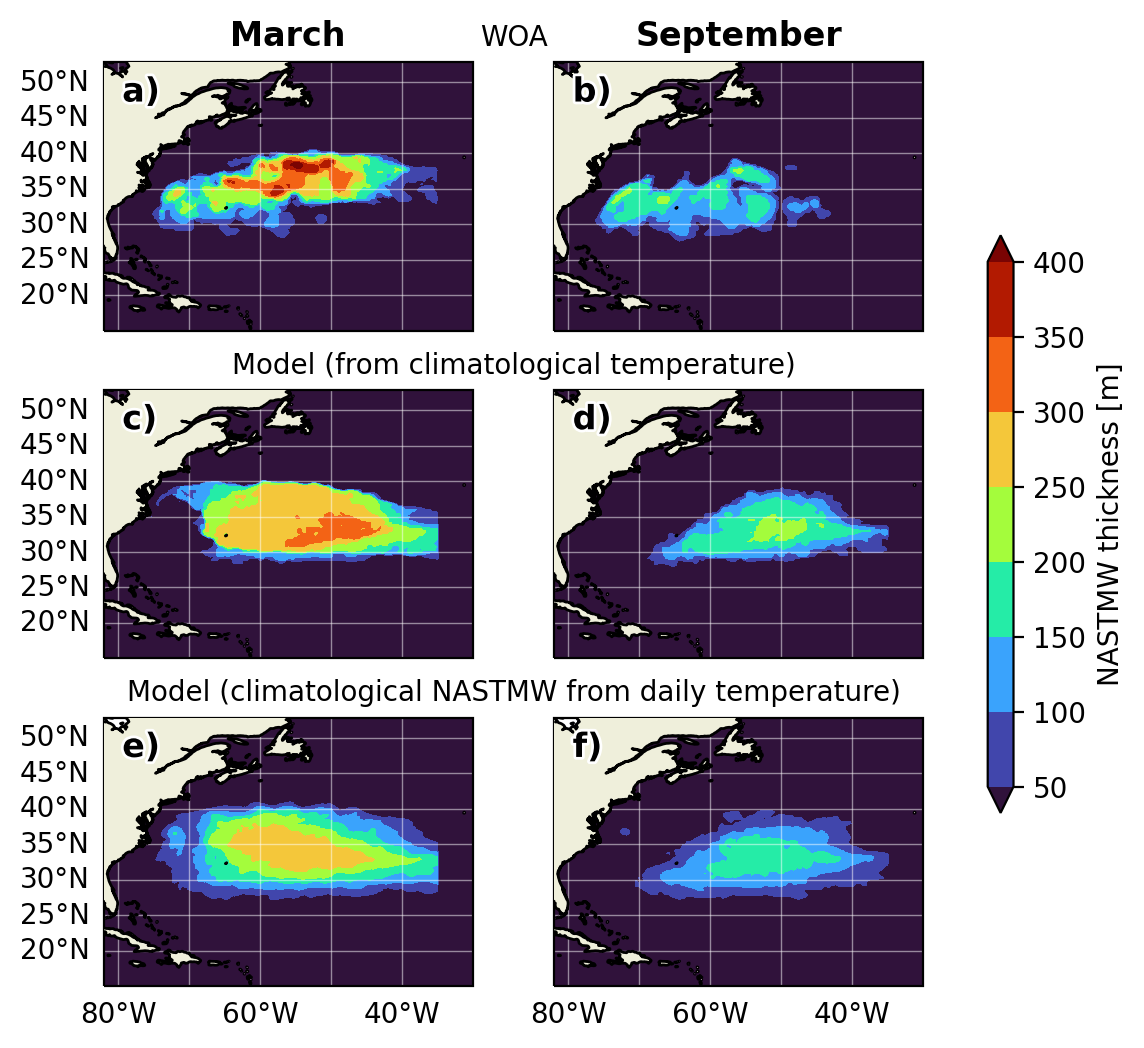

In [61]:
fig = plt.figure(figsize=(6, 6))
gs_super = fig.add_gridspec(1, 2, width_ratios=[1, 0.03], wspace=0.1)
gs_maps = gs_super[0].subgridspec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], wspace=0.1, hspace=0.22)
gs_cb = gs_super[1].subgridspec(3, 1, height_ratios=[0.25, 1, 0.25], hspace=0.1)

# first row will be WOA NASTMW
woa_strat_crit = 0.006
woa_lon, woa_lat = WOA_data_march_t.lon, WOA_data_march_t.lat
ax1 = fig.add_subplot(gs_maps[0, 0], projection=cart.crs.PlateCarree())
ax1.contourf(woa_lon, woa_lat, identify_edw_woa(WOA_data_march_t, strat_crit=woa_strat_crit)[1].where(woa_lon <-35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax1.gridlines(draw_labels=['left'], linewidth=0.5, color='white', alpha=0.5)
ax1.set_title("March", fontweight='bold')

ax2 = fig.add_subplot(gs_maps[0, 1], projection=cart.crs.PlateCarree())
ax2.contourf(woa_lon, woa_lat, identify_edw_woa(WOA_data_september_t, strat_crit=woa_strat_crit)[1].where(woa_lon <-35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax2.gridlines(linewidth=0.5, color='white', alpha=0.5)
ax2.set_title("September", fontweight='bold')

# second row will be model NASTMW (from single climatology temperature field)
model_strat_crit = 0.01
ax3 = fig.add_subplot(gs_maps[1, 0], projection=cart.crs.PlateCarree())
ax3.contourf(model_clim_T_03.nav_lon, model_clim_T_03.nav_lat, identify_edw_model(model_clim_T_03, temp_crit=[17, 20.5], strat_crit=model_strat_crit)[1].where(model_clim_T_03.nav_lon < -35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax3.gridlines(draw_labels=['left'], linewidth=0.5, color='white', alpha=0.5)
ax3.set_title(" ")


ax4 = fig.add_subplot(gs_maps[1, 1], projection=cart.crs.PlateCarree())
ax4.contourf(model_clim_T_09.nav_lon, model_clim_T_09.nav_lat, identify_edw_model(model_clim_T_09, temp_crit=[17, 20.5], strat_crit=model_strat_crit)[1].where(model_clim_T_03.nav_lon < -35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax4.gridlines(linewidth=0.5, color='white', alpha=0.5)
ax4.set_title(" ")

# third row will be average NASTMW
ax5 = fig.add_subplot(gs_maps[2, 0], projection=cart.crs.PlateCarree())
ax5.contourf(ds_clim_EDW_03.nav_lon, ds_clim_EDW_03.nav_lat, ds_clim_EDW_03.EDW_total_thickness.where(ds_clim_EDW_03.nav_lon < -35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax5.gridlines(draw_labels=['left', 'bottom'], linewidth=0.5, color='white', alpha=0.5)
ax5.set_title(" ")

ax6 = fig.add_subplot(gs_maps[2, 1], projection=cart.crs.PlateCarree())
field = ax6.contourf(ds_clim_EDW_09.nav_lon, ds_clim_EDW_09.nav_lat, ds_clim_EDW_09.EDW_total_thickness.where(ds_clim_EDW_03.nav_lon < -35, 0), cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax6.gridlines(draw_labels=['bottom'], linewidth=0.5, color='white', alpha=0.5)
ax6.set_title(" ")


for i, ax in enumerate(fig.axes):
    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
    ax.set_extent([-82, -30, 15, 50])
    ax.text(0.05, 0.95, f"{chr(ord('a') + i)})", transform=ax.transAxes, zorder=20, fontsize=12, color='black', fontweight='bold',path_effects=[pe.withStroke(linewidth=2, foreground='white')], va='top')

ax_top = fig.add_subplot(gs_maps[0, :])
ax_top.axis('off')
ax_top.set_title("WOA", fontsize=10)

ax_middle = fig.add_subplot(gs_maps[1, :])
ax_middle.axis('off')
ax_middle.set_title("Model (from climatological temperature)", fontsize=10)

ax_bottom = fig.add_subplot(gs_maps[2, :])
ax_bottom.axis('off')
ax_bottom.set_title("Model (climatological NASTMW from daily temperature)", fontsize=10)

ax_cb = fig.add_subplot(gs_cb[1])
fig.colorbar(field, cax=ax_cb, label="NASTMW thickness [m]")

plt.savefig("output/woa_model_NASTMW.png", dpi=300, bbox_inches='tight')

# Identify NASTMW in WOA

In [56]:
woa_edw_march_001_cells, woa_edw_march_001_thickness = identify_edw_woa(WOA_data_march_t, strat_crit=0.01)
woa_edw_march_0006_cells, woa_edw_march_0006_thickness = identify_edw_woa(WOA_data_march_t, strat_crit=0.006)

woa_edw_september_001_cells, woa_edw_september_001_thickness = identify_edw_woa(WOA_data_september_t, strat_crit=0.01)
woa_edw_september_0006_cells, woa_edw_september_0006_thickness = identify_edw_woa(WOA_data_september_t, strat_crit=0.006)

In [61]:
woa_edw_winter_0006_cells, woa_edw_winter_0006_thickness = identify_edw_woa(WOA_data_winter, strat_crit=0.006)
woa_edw_summer_0006_cells, woa_edw_summer_0006_thickness = identify_edw_woa(WOA_data_summer, strat_crit=0.006)

# NASTMW sensitivity analysis

In [ ]:
model_clim_09_edw, model_clim_09_edw_thickness = identify_edw_model(model_clim_T_09, temp_crit=[17, 20.5])
model_clim_03_edw, model_clim_03_edw_thickness = identify_edw_model(model_clim_T_03, temp_crit=[17, 20.5])

In [11]:
model_NASTMW_20000301 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4_EDW/freeglorys2v4-NorthAtlanticGoM-daily_EDW_2000-03-01_s0.01-t17.0_20.5.nc")
model_NASTMW_20000901 = xr.open_dataset("/nethome/4302001/local_data/FREEGLORYS2V4_EDW/freeglorys2v4-NorthAtlanticGoM-daily_EDW_2000-09-01_s0.01-t17.0_20.5.nc")

In [12]:
def strict_EDW_thickness_from_ds(ds):
    """
    Compute the thickness of the EDW from a precomputed dataset. Apply the contiguity and layer thickness criteria.
    """
    NASTMW_filter = (ds.EDW_layer_thickness > 50) * (ds.EDW_part_of_biggest_blob + ds.EDW_part_of_smaller_blob)
    # NASTMW_filter = (ds.EDW_layer_thickness > 50) * (ds.EDW_part_of_biggest_blob)

    level_thickness = mesh_z.e3t_1d.rename({'z':'deptht'})
    level_thickness['deptht'] = NASTMW_filter.deptht
    return (NASTMW_filter.astype(float) * level_thickness).sum('deptht')

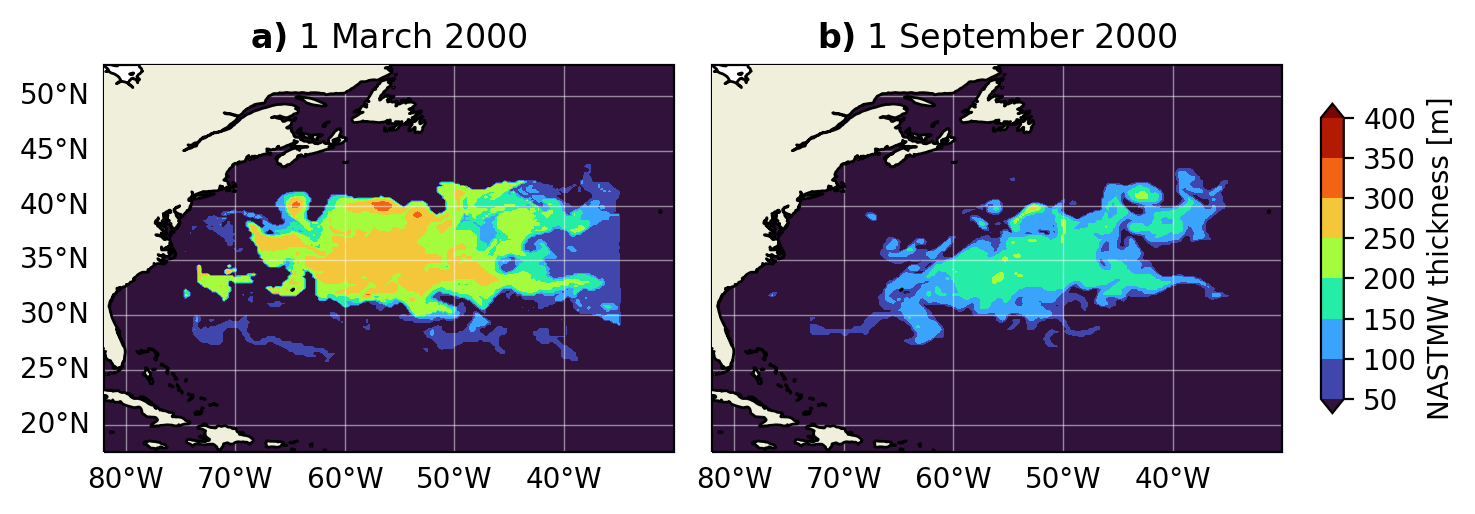

In [20]:
fig = plt.figure(figsize=(8,3))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.1)

thickness_march_2000 = strict_EDW_thickness_from_ds(model_NASTMW_20000301)
ax_march = fig.add_subplot(gs[0, 0], projection=cart.crs.PlateCarree())
ax_march.set_title(r"$\bf{a)}$ 1 March 2000")
ax_march.contourf(thickness_march_2000.nav_lon, thickness_march_2000.nav_lat, thickness_march_2000, cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax_march.gridlines(draw_labels=['left', 'bottom'], linewidth=0.5, color='white', alpha=0.5)

thickness_september_2000 = strict_EDW_thickness_from_ds(model_NASTMW_20000901)
ax_sept = fig.add_subplot(gs[0, 1], projection=cart.crs.PlateCarree())
ax_sept.set_title(r"$\bf{b)}$ 1 September 2000")
field = ax_sept.contourf(thickness_september_2000.nav_lon, thickness_september_2000.nav_lat, thickness_september_2000, cmap='turbo', levels=np.arange(50, 401, 50), extend='both')
ax_sept.gridlines(draw_labels=['bottom'], linewidth=0.5, color='white', alpha=0.5)

for ax in [ax_march, ax_sept]:
    ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
    ax.set_extent([-82, -30, 17.5, 50])

cbar_gs = gs[0, 2].subgridspec(3, 1, height_ratios=[0.2, 1, 0.2], hspace=0.1)
cbar_ax = fig.add_subplot(cbar_gs[1])
cbar = fig.colorbar(field, cax=cbar_ax, label="NASTMW thickness [m]")

plt.savefig("output/model_NASTMW_snapshots.png", dpi=300, bbox_inches='tight')

In [93]:
import string

def index_to_label(index):
    alphabet = string.ascii_lowercase  # "abcdefghijklmnopqrstuvwxyz"
    if index < 26:
        # Single letter labels
        return alphabet[index]
    else:
        # Double letter labels
        div, rem = divmod(index, 26)
        return alphabet[div-1] + alphabet[rem]

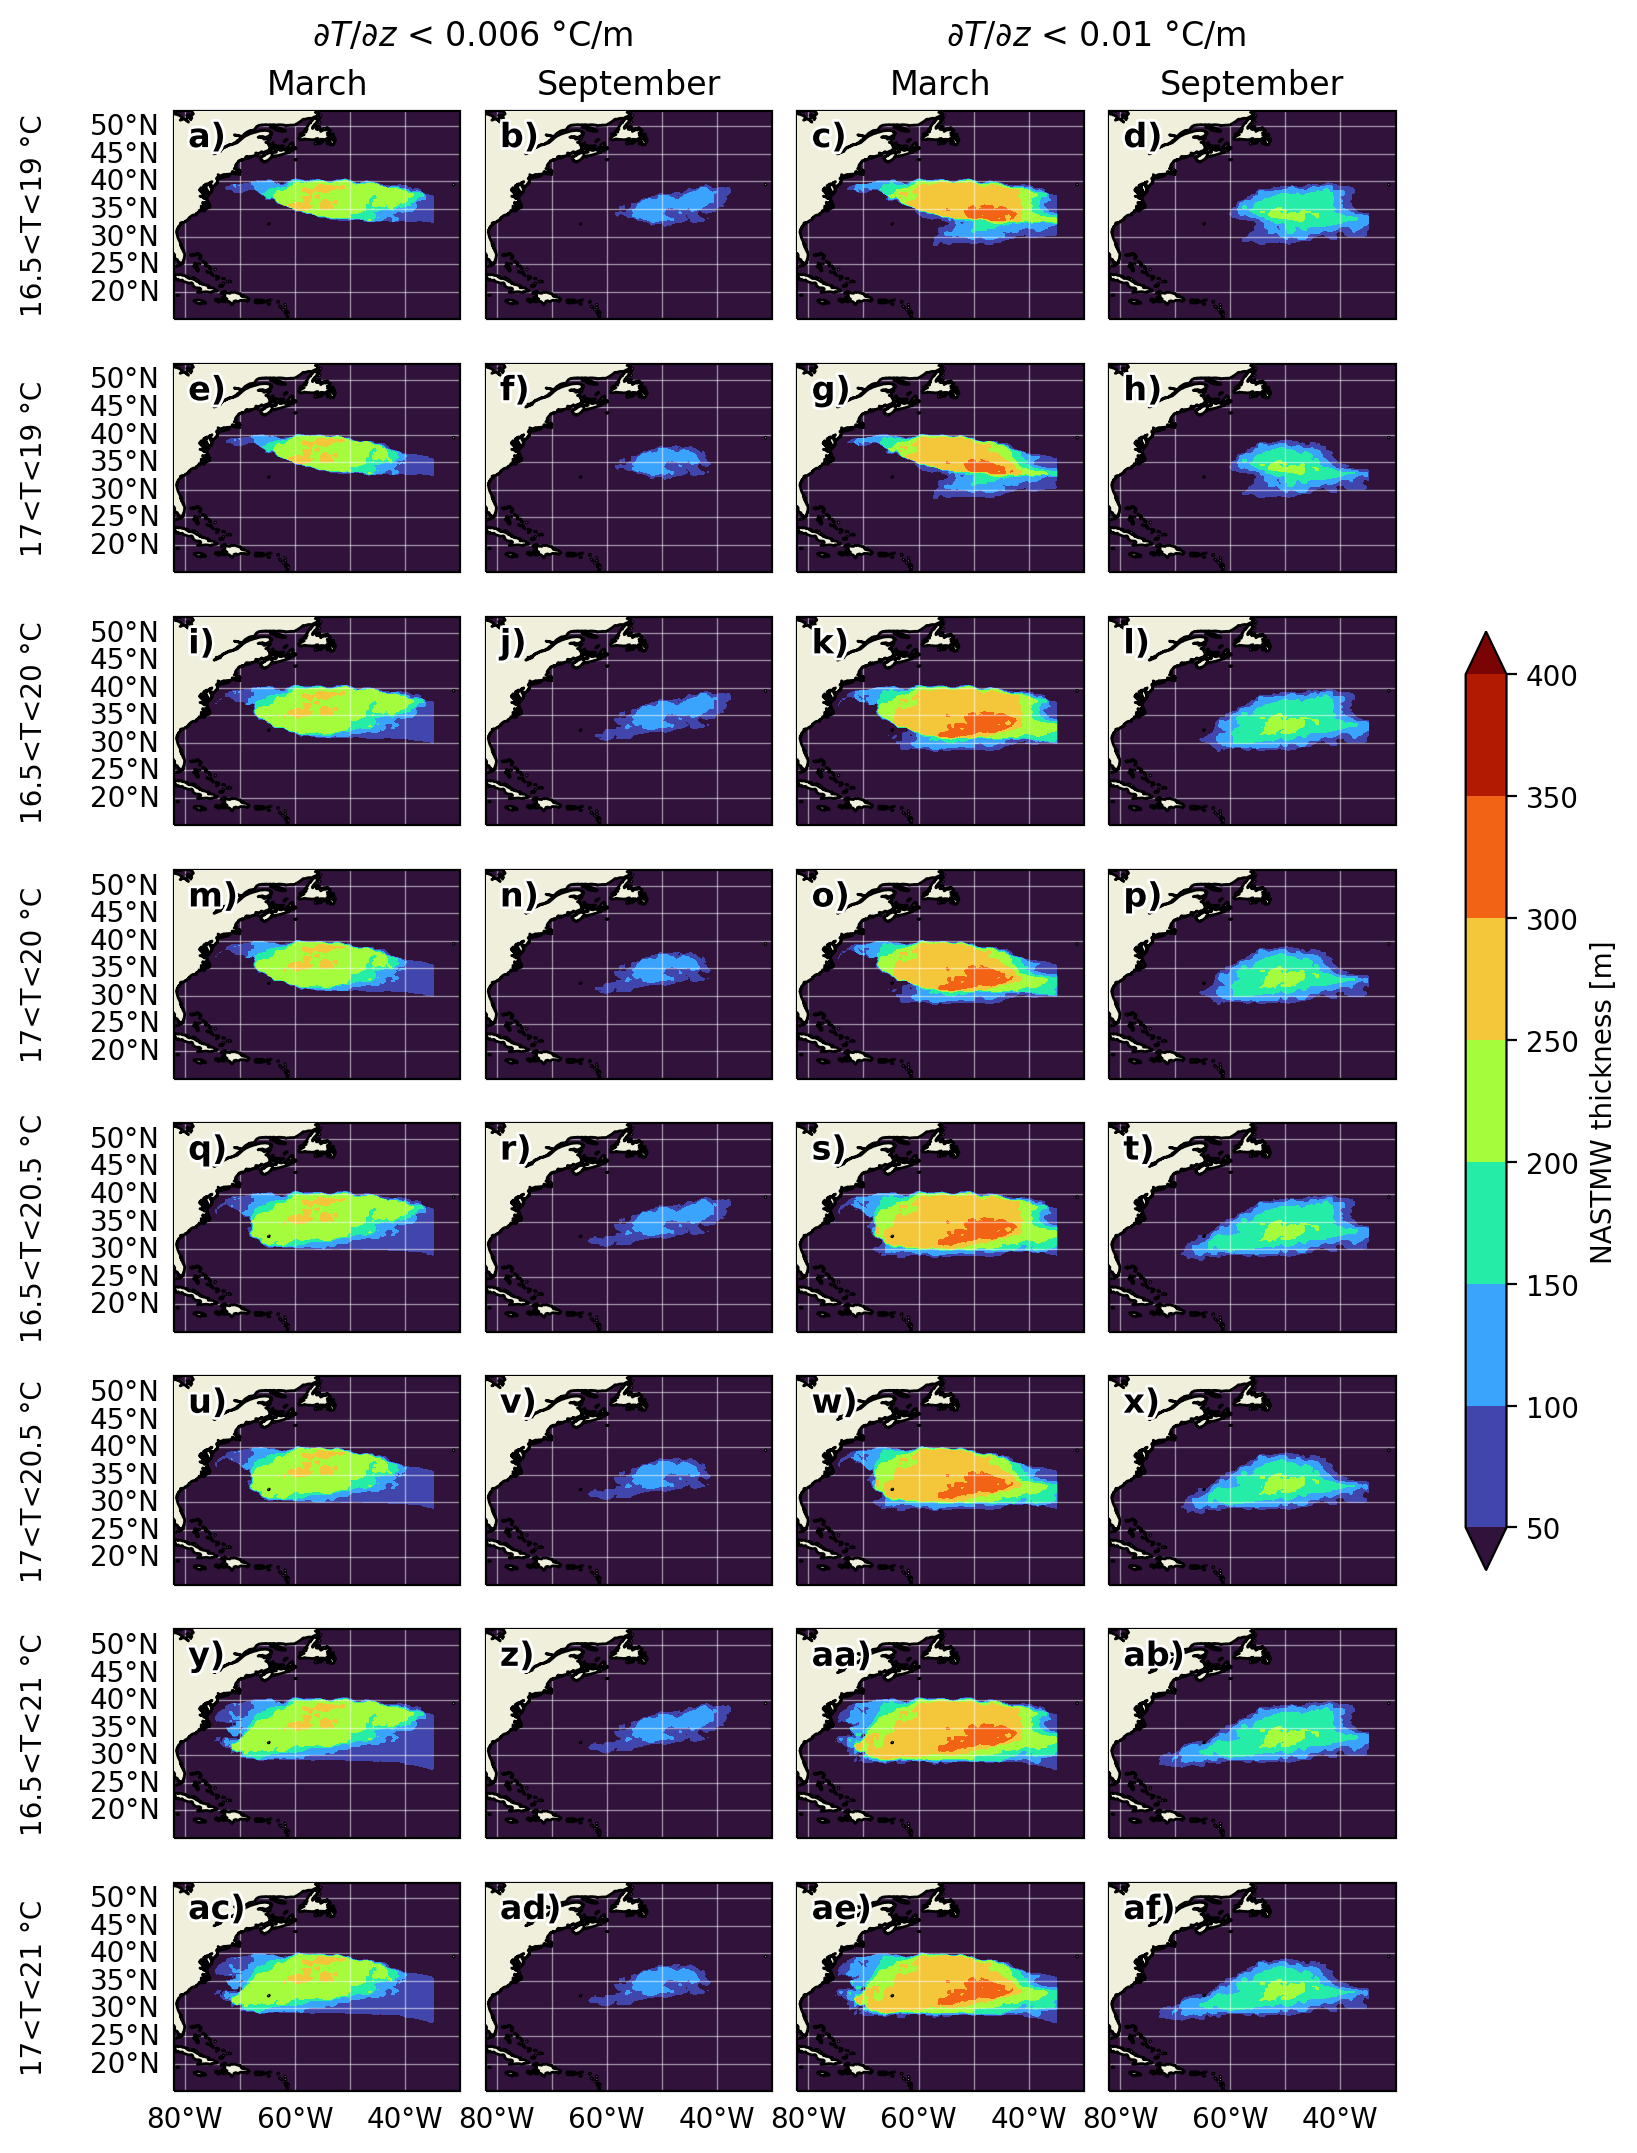

In [113]:
fig = plt.figure(figsize=(9.5, 13))
gs_super = fig.add_gridspec(1, 2, width_ratios=[1, 0.03], wspace=0.1)
gs_maps = gs_super[0].subgridspec(8, 5, width_ratios=[0.4, 1, 1, 1, 1], height_ratios=[1, 1, 1, 1, 1,1, 1, 1], wspace=0.1, hspace=0.1)
gs_cb = gs_super[1].subgridspec(3, 1, height_ratios=[0.5, 1, 0.5], hspace=0.1)

strat_crits = [0.006, 0.01]
min_temps = [16.5, 17]
max_temps = [19, 20, 20.5, 21]
seasons = {"March" : model_clim_T_03, "September": model_clim_T_09}

ax_dict = {}

for row, max_temp in enumerate(max_temps):
    for sub_row, min_temp in enumerate(min_temps):
        for col, strat_crit in enumerate(strat_crits):
            for sub_col, (season_name, model_clim_T) in enumerate(seasons.items()):
                ax = fig.add_subplot(gs_maps[2*row + sub_row, 2*col + sub_col + 1], projection=cart.crs.PlateCarree())

                labelidx = col * 2 + sub_col + (row * 2 + sub_row) * 4

                edw_cells, edw_thickness = identify_edw_model(model_clim_T, temp_crit=[min_temp, max_temp], strat_crit=strat_crit)
                edw_thickness = edw_thickness.where(model_clim_T.nav_lon < -35, 0)

                field = ax.contourf(edw_thickness.nav_lon, edw_thickness.nav_lat, edw_thickness, cmap='turbo', levels=np.arange(50, 401, 50), extend='both')

                # ax.set_title(f"{season_name}, {strat_crit}, {min_temp}, {max_temp}")
                ax.add_feature(cart.feature.LAND, zorder=18, edgecolor='black')
                ax.set_extent([-82, -30, 15, 50])

                labels = []
                if col == 0 and sub_col == 0:
                    labels.append('left')
                    
                    text_ax = fig.add_subplot(gs_maps[2*row + sub_row, 0])
                    text_ax.axis('off')
                    text_ax.text(0, 0.5, f"{min_temp}<T<{max_temp} °C", rotation=90, transform=text_ax.transAxes, zorder=20, fontsize=10, color='black', ha='center', va='center')

                if row == 3 and sub_row == 1:
                    labels.append('bottom')
                ax.gridlines(draw_labels=labels, linewidth=0.5, color='white', alpha=0.5)
                ax.text(0.05, 0.95, f"{index_to_label(labelidx)})", transform=ax.transAxes, zorder=20, fontsize=12, color='black', fontweight='bold',path_effects=[pe.withStroke(linewidth=2, foreground='white')], va='top')
                ax_dict[labelidx] = ax
 

ax_strat_strict = fig.add_subplot(gs_maps[0, 1:3])
ax_strat_strict.axis('off')
ax_strat_strict.set_title(r"$\partial T/\partial z$ < 0.006 °C/m" + "\n")

ax_strat_loose = fig.add_subplot(gs_maps[0, 3:])
ax_strat_loose.axis('off')
ax_strat_loose.set_title(r"$\partial T/\partial z$ < 0.01 °C/m"+ "\n")

ax_dict[0].set_title("March")
ax_dict[1].set_title("September")
ax_dict[2].set_title("March")
ax_dict[3].set_title("September")

ax_cb = fig.add_subplot(gs_cb[1])
fig.colorbar(field, cax=ax_cb, label="NASTMW thickness [m]")

plt.savefig("output/model_NASTMW_sensitivity.png", dpi=300, bbox_inches='tight')